# Bug triage with Deep Learning

In [1]:
import keras

Using TensorFlow backend.


In [2]:
from __future__ import print_function, division

In [3]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [4]:
from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.initializers import TruncatedNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import optimizers

In [5]:
from methods.baseline import Baseline

## Auxiliary methods

## Configurações Globais

In [6]:
MAX_SEQUENCE_LENGTH_T = 20 # 40
MAX_SEQUENCE_LENGTH_D = 200 # 200
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000

### Parse bugs preproprecessed

In [7]:
# Domain to use
DOMAIN = 'eclipse'
# Dataset paths
DIR = 'data/processed/{}'.format(DOMAIN)
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
# Glove embeddings
GLOVE_DIR='data/embed'
# Log keras
LOG_DIR='logs/training'
# Checkpoint keras
FILE_PATH = "checkpoint_baseline_1000epoch_10steps_1024batch({})".format(DOMAIN)
# Save model
SAVE_PATH = 'baseline_1000epoch_10steps_1024batch({})'.format(DOMAIN)

In [8]:
baseline = Baseline(DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

#### Loading bug ids in memory

In [9]:
baseline.load_ids(DIR)
len(baseline.bug_ids)

212512

### Dicionário de títulos e descrições

In [10]:
%%time

baseline.load_preprocess()
len(baseline.sentence_dict)


Wall time: 2h 52min 37s


## Geração de batches

### Generating tiple of batches

In [11]:
%%time
baseline.prepare_dataset()

Reading train data
Reading the test...



Reading test data
Wall time: 3.55 s


In [12]:
baseline.load_bugs()

In [13]:
baseline.bug_set[2521]

{'bug_severity': '6\n',
 'bug_status': '1\n',
 'component': '227\n',
 'creation_ts': '2001-10-10 22:38:00 -0400',
 'delta_ts': '2005-05-10 14:55:51 -0400',
 'description': 'steps minimize all your windows go to any window and select the window menu pick any window notice that it only gets selected and not maximized this happens in country as well notes',
 'description_word': array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,

In [14]:
%%time

batch_size = 1024
batch_size_test = 512

# we want a constant validation group to have a frame of reference for model performance
train_gen = baseline.siam_gen(baseline.train_data, baseline.dup_sets_train, batch_size, 1)
valid_input_sample, valid_input_pos, valid_input_neg, valid_sim = baseline.batch_iterator(baseline.train_data, 
                                                                                          baseline.dup_sets_train, 
                                                                                          batch_size_test, 1)
test_gen = ([valid_input_sample['title'], valid_input_pos['title'], valid_input_neg['title'], 
             valid_input_sample['description'], valid_input_pos['description'], valid_input_neg['description']], valid_sim)

Wall time: 256 ms


In [15]:
valid_input_sample['title'].shape, valid_input_sample['description'].shape, valid_input_sample['info'].shape, valid_sim.shape

((512, 20), (512, 200), (512, 1682), (512,))

### Validar entrada

In [16]:
%%time 

baseline.display_batch(baseline.train_data, baseline.dup_sets_train, 5)

***Title***: the editor does not set the archive attribute
***Title***: ressource changes leave archive bit unaffected
***Description***: the file system in organization offers a functionality for the taking of incremental backups files created and modified get the archive attribute set organization backup tools in general including organization can take incremental backups based on the archive attribute if set the file is backed up and the attribute is cleared it turns out that organization s editor modifies files without setting the archive attribute this is probably a typical organization feature and i know your aim at implementing features on an operating system independent level which i highly respect however i use this attribute for my record of files that should be checked in to organization in date i reset the bit after the daily morning organization checkout and can look for files dir aa s java that have been modified or created when summarizing date s work in date organizatio

***Description***: build id i steps to reproduce open a organization file using organization organization editor the organization file contains jsp use bean scriptlet javascript organization etc more information the following exception was printed out on organization java lang illegal argument exception argument not valid at org eclipse swt swt error swt java at org eclipse swt swt error swt java at org eclipse swt swt error swt java at org eclipse swt custom styled text set style ranges styled text java at org eclipse swt custom styled text replace style ranges styled text java at org eclipse jface text text viewer add presentation text viewer java at org eclipse jface text text viewer change text presentation text viewer java at org eclipse wst sse ui internal provisional style structured presentation reconciler apply text region collection structured presentation reconciler java at org eclipse wst sse ui internal provisional style structured presentation reconciler process damage st

***Description***: build id i steps to reproduce create a new file test jsp with the following content style foo background image url image path img gif style open it with the organization editor more information i have verified this issue on organization and country person is the stack trace java lang illegal argument exception argument not valid at org eclipse swt swt error swt java at org eclipse swt swt error swt java at org eclipse swt swt error swt java at org eclipse swt custom styled text set style ranges styled text java at org eclipse swt custom styled text replace style ranges styled text java at org eclipse jface text text viewer add presentation text viewer java at org eclipse jface text text viewer change text presentation text viewer java at org eclipse wst sse ui internal provisional style structured presentation reconciler apply text region collection structured presentation reconciler java at org eclipse wst sse ui internal provisional style structured presentation re

## Pre-trained embeddings

Loading pretrained word vectors

### Glove

In [17]:
%%time

baseline.generating_embed(GLOVE_DIR=GLOVE_DIR, EMBEDDING_DIM=EMBEDDING_DIM, MAX_NB_WORDS=MAX_NB_WORDS)


Total 1917494 word vectors in Glove 42B 300d.
Found 128293 unique tokens.



Wall time: 14min 12s


## Towards Accurate Duplicate Bug Retrieval Using Deep Learning Techniques

https://github.com/tqtg/DuplicateBugFinder

### CNN with filter 3,4,5

In [18]:
import keras
from keras.layers import GlobalMaxPooling1D

def cnn_model(embeddings, num_words, embedding_dim, max_sequence_length, trainable):

  embedding_layer = Embedding(num_words,
                              embedding_dim,
                              weights=[embeddings],
                              input_length=max_sequence_length,
                              trainable=trainable)

  sequence_input = Input(shape=(max_sequence_length,), name='Feature_BugInput')
  embedded_sequences = embedding_layer(sequence_input)

  # Yoon Kim model (https://arxiv.org/abs/1408.5882)
  # best combination filter (3, 4, 5) e 128 e 256
  convs = []
  filter_sizes = [3, 4, 5]

  for filter_size in filter_sizes:
      l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
      l_pool = MaxPooling1D(pool_size=3)(l_conv)
      convs.append(l_pool)

  # l_merge = Merge(mode='concat', concat_axis=1)(convs)

  l_merge = Concatenate(axis=1)(convs)

  # add a 1D convnet with global maxpooling, instead of Yoon Kim model
  conv = Conv1D(filters=256, kernel_size=3, activation='relu')(l_merge)
  layer = GlobalMaxPooling1D()(conv) # pool_size=3
  # Original Yoon Kim model
  #x = Flatten()(pool)
  #x = Dropout(0.5)(x)
  #layer = Activation('relu')(pool)

  cnn_feature_model = Model(inputs=[sequence_input], outputs=[layer], name = 'FeatureCNNGenerationModel') # inputs=visible
  
  return cnn_feature_model

### Bi-LSTM

In [93]:
from keras.layers import Dense, Input, LSTM, Dropout, Bidirectional

def lstm_model(embeddings, num_words, embedding_dim, max_sequence_length, trainable):
  number_lstm_units = 50
  rate_drop_lstm = 0
  recurrent_dropout = 0

  embedding_layer = Embedding(num_words,
                          embedding_dim,
                          weights=[embeddings],
                          input_length=max_sequence_length,
                          trainable=trainable)

  sequence_input = Input(shape=(max_sequence_length, ), name='Feature_BugInput')
  embedded_sequences = embedding_layer(sequence_input)

   # Creating LSTM Encoder
  lstm_layer = Bidirectional(LSTM(number_lstm_units, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm), merge_mode='sum')

  layer = lstm_layer(embedded_sequences)

  #layer = Activation('relu')(x)

  lstm_feature_model = Model(inputs=[sequence_input], outputs=[layer], name = 'FeatureLstmGenerationModel') # inputs=visible
  
  return lstm_feature_model

### MLP

In [20]:
def mlp_model(input_size):
    info_input = Input(shape=(input_size, ), name='Feature_BugInput')
    
    x = Dense(input_size)(info_input)
    x = Activation('tanh')(x)
    x = BatchNormalization()(x)
    x = Dense(input_size // 2)(x)
    x = Activation('tanh')(x)
    x = BatchNormalization()(x)
    
    layer = Dense(256)(x)
    
    mlp_feature_model = Model(inputs=[info_input], outputs=[layer], name = 'FeatureMlpGenerationModel')
    
    return mlp_feature_model

### Siamese model

In [21]:
from keras import backend as K
import tensorflow as tf

def l2_normalize(x, axis):
    norm = K.sqrt(K.sum(K.square(x), axis=axis, keepdims=True))
    return K.maximum(x, K.epsilon()) / K.maximum(norm, K.epsilon())

# https://github.com/keras-team/keras/issues/3031
# https://github.com/keras-team/keras/issues/8335
def cosine_distance(inputs):
    x, y = inputs
    x = l2_normalize(x, axis=-1)
    y = l2_normalize(y, axis=-1)
    similarity = K.batch_dot(x, y, axes=1)
    distance = K.constant(1) - similarity
    # Distance goes from 0 to 2 in theory, but from 0 to 1 if x and y are both
    # positive (which is the case after ReLU activation).
    return K.mean(distance, axis=-1)

def margin_loss(y_true, y_pred):
    margin = K.constant(1.0)
    return K.mean(K.maximum(0.0, margin - y_pred[0] + y_pred[1]))

def pos_distance(y_true, y_pred):
    return K.mean(y_pred[0])

def neg_distance(y_true, y_pred):
    return K.mean(y_pred[1])

def stack_tensors(vects):
    return K.squeeze(K.stack(vects),axis=1) # stack adds a new dim. So squeeze it
    # better method is to use concatenate
    return K.concatenate(vects,axis=1)

In [22]:
from keras.layers import concatenate, Add, Lambda, merge
from keras.optimizers import Adam

def siamese_model(lstm_feature_model, cnn_feature_model, mlp_feature_model, sequence_length_info, 
                  max_sequence_length_t, max_sequence_length_d):
  
    bug_t_in = Input(shape = (max_sequence_length_t, ), name = 'title_in')
    bug_t_pos = Input(shape = (max_sequence_length_t, ), name = 'title_pos')
    bug_t_neg = Input(shape = (max_sequence_length_t, ), name = 'title_neg')

    bug_d_in = Input(shape = (max_sequence_length_d, ), name = 'desc_in')
    bug_d_pos = Input(shape = (max_sequence_length_d, ), name = 'desc_pos')
    bug_d_neg = Input(shape = (max_sequence_length_d, ), name = 'desc_neg')
    
    bug_i_in = Input(shape = (sequence_length_info, ), name = 'info_in')
    bug_i_pos = Input(shape = (sequence_length_info, ), name = 'info_pos')
    bug_i_neg = Input(shape = (sequence_length_info, ), name = 'info_neg')

    bug_t_in_feat_lstm = lstm_feature_model(bug_t_in)
    bug_t_pos_feat_lstm = lstm_feature_model(bug_t_pos)
    bug_t_neg_feat_lstm = lstm_feature_model(bug_t_neg)

    bug_d_in_feat_cnn = cnn_feature_model(bug_d_in)
    bug_d_pos_feat_cnn = cnn_feature_model(bug_d_pos)
    bug_d_neg_feat_cnn = cnn_feature_model(bug_d_neg)
    
    bug_i_in_feat_mlp = mlp_feature_model(bug_i_in)
    bug_i_pos_feat_mlp = mlp_feature_model(bug_i_pos)
    bug_i_neg_feat_mlp = mlp_feature_model(bug_i_neg)

    encoded_anchor = concatenate([bug_i_in_feat_mlp, bug_t_in_feat_lstm, bug_d_in_feat_cnn], name = 'merge_features_in')
    encoded_positive = concatenate([bug_i_pos_feat_mlp, bug_t_pos_feat_lstm, bug_d_pos_feat_cnn], name = 'merge_features_pos')
    encoded_negative = concatenate([bug_i_neg_feat_mlp, bug_t_neg_feat_lstm, bug_d_neg_feat_cnn], name = 'merge_features_neg')

    positive_d = Lambda(cosine_distance)([encoded_anchor, encoded_positive])
    negative_d = Lambda(cosine_distance)([encoded_anchor, encoded_negative])
    
    # Loss function only works with a single output
    output = Lambda(
        lambda vects: K.stack(vects),
        name='stack-distances',
    )([positive_d, negative_d])
  
    similarity_model = Model(inputs = [bug_t_in, bug_t_pos, bug_t_neg, 
                                       bug_d_in, bug_d_pos, bug_d_neg, 
                                       bug_i_in, bug_i_pos, bug_i_neg], 
                           outputs = output, name = 'Similarity_Model')

    # setup the optimization process 
    similarity_model.compile(optimizer='adam', loss=margin_loss, metrics=[pos_distance, neg_distance]) # 'categorical_crossentropy' 

    return similarity_model

## Experiment

##### Logs

In [23]:
tbCallBack = keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=0, write_graph=True, write_images=True)

##### Checkpoint

In [24]:
from keras.callbacks import ModelCheckpoint

def checkpoint_model(name):
    m_dir = os.path.join('checkpoint')
    if not os.path.exists(m_dir):
        os.mkdir(m_dir)
    return ModelCheckpoint(os.path.join(m_dir, "{}.hdf5".format(name)), monitor='loss', \
                                        verbose=1, save_best_only=False, mode='min', period=1)

# checkpoint
checkpoint = checkpoint_model(FILE_PATH)

In [131]:
%%time
import keras

# Inspired on https://'pastebin.com/TaGFdcBA
# TODO: https://stackoverflow.com/questions/49941903/keras-compute-cosine-distance-between-two-flattened-outputs
keras.backend.clear_session()

number_of_columns_info = valid_input_sample['info'].shape[1]

cnn_feature_model = cnn_model(embeddings=baseline.embedding_matrix, 
                              num_words=len(baseline.word_index) + 1, 
                              embedding_dim=EMBEDDING_DIM, 
                              max_sequence_length=MAX_SEQUENCE_LENGTH_D, 
                              trainable=False)

lstm_feature_model = lstm_model(embeddings=baseline.embedding_matrix, 
                              num_words=len(baseline.word_index) + 1, 
                              embedding_dim=EMBEDDING_DIM, 
                              max_sequence_length=MAX_SEQUENCE_LENGTH_T, 
                              trainable=False)

mlp_feature_model = mlp_model(number_of_columns_info)

similarity_model = siamese_model(lstm_feature_model, cnn_feature_model, mlp_feature_model, 
                                     number_of_columns_info, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

# cnn_feature_model.summary()
# lstm_feature_model.summary()
similarity_model.summary()

'''
    Experiments log
    * baseline = mlp + cnn + bilstm
    
    - training with 1000 epochs in 20 had loss 0.91 (baseline)
    - training with 20 epohcs had loss 0.91 (batch normalization and activation tahn in MLP model)
    - training with 1000 epochs had loss 0.2 (batch normalization and activation tahn in MLP model)
    - training with 300 epochs had loss 0.2 (batch normalization and activation tahn in MLP model)
    - training with 100 epochs had loss 0.4 (batch normalization and activation tahn in MLP model)
'''
h = similarity_model.fit_generator(train_gen, 
                               steps_per_epoch = 10,
                                             epochs = 300,
                                             verbose = True,
                                               callbacks=[tbCallBack, checkpoint]
                                              )  # 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
info_in (InputLayer)            (None, 1682)         0                                            
__________________________________________________________________________________________________
title_in (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
desc_in (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
info_pos (InputLayer)           (None, 1682)         0                                            
__________________________________________________________________________________________________
title_pos 

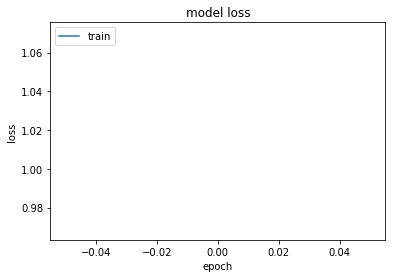

In [97]:
loss=h.history['loss']

plt.plot(loss, label='loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [27]:
def save_model(model, name):
    m_dir = os.path.join('modelos')
    if not os.path.exists(m_dir):
        os.mkdir(m_dir)
    model.save(os.path.join(m_dir, "model_{}.h5".format(name)))
    print("Saved model to disk")

In [219]:
save_model(similarity_model, SAVE_PATH)

Saved model to disk


### Using the feature layers

In [30]:
def get_info(baseline, bug):
    info = np.concatenate((
        baseline.to_one_hot(bug['bug_severity'], baseline.info_dict['bug_severity']),
        baseline.to_one_hot(bug['bug_status'], baseline.info_dict['bug_status']),
        baseline.to_one_hot(bug['component'], baseline.info_dict['component']),
        baseline.to_one_hot(bug['priority'], baseline.info_dict['priority']),
        baseline.to_one_hot(bug['product'], baseline.info_dict['product']),
        baseline.to_one_hot(bug['version'], baseline.info_dict['version']))
    )
    return info

In [220]:
from scipy import spatial
bug_id = [96204, 2]# [269536, 2]
bug_set = baseline.get_bug_set()
dup_a, dup_b = bug_id
bug_a = bug_set[dup_a]
bug_b = bug_set[dup_b]

#### LSTM feature

In [221]:
bug_vector_a_t = lstm_feature_model.predict(np.array([bug_a['title_word']]))
bug_vector_b_t = lstm_feature_model.predict(np.array([bug_b['title_word']]))
result = 1 - spatial.distance.cosine(bug_vector_a_t, bug_vector_b_t)
result

0.9941076040267944

In [199]:
bug_vector_a_t, bug_vector_b_t

(array([[-0.56330323,  1.1621387 ,  0.30166683,  0.6682679 ,  0.50840724,
         -0.5736087 , -0.03571591, -1.0374614 ,  0.9104828 ,  1.1263161 ,
          0.01986182, -1.0691348 , -0.5593003 ,  0.63369286,  0.86244226,
         -0.0208185 ,  0.88220704,  0.86501396, -1.0443859 , -1.2505665 ,
          1.1631598 ,  1.2496418 ,  1.3722248 ,  1.2677189 , -0.57093096,
         -0.2661015 ,  1.0392275 , -1.1979573 ,  0.4718321 , -0.21939963,
         -1.2715449 ,  1.6430686 ,  0.97248286, -0.00434712, -1.035367  ,
          1.1876817 ,  1.5709381 , -1.676405  ,  1.4266727 ,  1.276109  ,
          0.32117975, -1.3292586 , -0.7819005 , -0.372718  , -1.014836  ,
          1.3030291 , -0.47162652, -0.83890694, -1.1547184 , -1.3851432 ]],
       dtype=float32),
 array([[-0.64417   ,  1.3253757 ,  0.35075915,  0.66156936,  0.45631412,
         -0.57823247, -0.12719405, -1.0578524 ,  0.7371274 ,  1.0944518 ,
          0.02875525, -1.1362019 , -0.81066227,  0.7479145 ,  0.8920927 ,
         -0.0

#### CNN feature

In [222]:
bug_vector_a_d = cnn_feature_model.predict(np.array([bug_a['description_word']]))
bug_vector_b_d = cnn_feature_model.predict(np.array([bug_b['description_word']]))
result = 1 - spatial.distance.cosine(bug_vector_a_d, bug_vector_b_d)
result

0.9998556971549988

In [201]:
bug_vector_a_d, bug_vector_b_d

(array([[10.07147   , 10.912041  ,  9.032252  ,  4.9383106 , 13.140688  ,
          6.768425  , 11.187926  , 10.696349  ,  8.561165  , 11.836345  ,
          8.314423  ,  6.7781916 ,  5.9566298 , 13.284679  , 11.04214   ,
         11.091284  , 10.409637  , 10.38621   ,  9.942392  ,  8.893408  ,
         12.744414  , -1.4912491 , -4.8088455 ,  6.649752  ,  9.029418  ,
          9.408507  , 10.988234  , -0.4908635 , 10.580982  , -0.48465863,
         12.244207  , 10.554687  ,  7.9546947 , 10.784753  ,  9.512853  ,
          7.4624276 ,  9.4706135 ,  4.606911  ,  9.362631  , 10.879543  ,
         11.787706  , 11.476833  , 13.8656845 ,  9.27706   , 10.051373  ,
         -0.88210356,  6.9138923 ,  6.8094807 ,  7.7781205 ,  9.019117  ,
          8.282433  , 17.4465    , -1.1300299 ,  6.2239494 ,  6.3990335 ,
         13.500481  ,  5.037914  , 11.567809  ,  9.777412  , 12.066111  ,
          7.1972017 , 13.018527  ,  7.086965  ,  9.922598  , 16.145233  ,
          9.995081  , 12.866392  , 10.

#### MLP feature

In [223]:
bug_vector_a_i = mlp_feature_model.predict(np.array([get_info(baseline, bug_a)]))
bug_vector_b_i = mlp_feature_model.predict(np.array([get_info(baseline, bug_b)]))
result = 1 - spatial.distance.cosine(bug_vector_a_i, bug_vector_b_i)
result

0.18021604418754578

In [204]:
bug_vector_a_i, bug_vector_b_i

(array([[-0.9450885 , -1.8798165 ,  0.79883826,  0.5185874 ,  0.33421737,
         -1.242396  , -0.5265256 , -0.803     ,  0.0318373 , -0.91021645,
         -1.5274704 , -1.5173157 ,  1.2560936 ,  0.32772243, -0.54364175,
          3.3362563 , -1.1896609 ,  1.8684098 ,  0.18955332, -4.40448   ,
         -5.816929  ,  0.24000752, -5.769896  , -1.5679039 , -5.9977775 ,
         -0.5520679 ,  0.4380633 , -0.82048506,  1.8269652 , -0.13862886,
          1.0038466 , -3.557904  ,  1.0256451 , -0.5178889 , -0.16052175,
          1.5630014 , -5.805288  , -0.63498825, -0.10015874, -0.35224092,
         -0.29583004, -0.08083088, -0.73366994, -1.2414439 , -0.3343113 ,
         -0.99561167,  0.40882584, -2.5945487 , -3.028087  , -0.2437438 ,
          0.07530952, -2.679733  , -0.93167406, -0.4818062 , -0.4637776 ,
          0.32792282,  0.34870887,  1.7013679 , -0.3394085 , -1.2017105 ,
         -4.233526  , -3.4726975 , -2.6310892 ,  0.5733873 ,  0.5036938 ,
         -3.8623326 , -1.2614491 , -1.

#### Merge features

In [224]:
bug_vector_a = np.concatenate([ bug_vector_a_t, bug_vector_a_d, bug_vector_a_i ], -1)
bug_vector_b = np.concatenate([ bug_vector_b_t, bug_vector_b_d, bug_vector_b_i ], -1)
result = 1 - spatial.distance.cosine(bug_vector_a, bug_vector_b)
result

0.9728338122367859

In [168]:
bug_vector_a, bug_vector_b

(array([[-5.49278259e-01,  1.31407785e+00,  2.83172548e-01,
          5.89546442e-01,  5.07808089e-01, -6.40580893e-01,
         -8.83755833e-02, -9.29789841e-01,  8.12460124e-01,
          1.00836492e+00,  9.22579765e-02, -1.11150980e+00,
         -6.53047323e-01,  6.82515919e-01,  1.00490701e+00,
         -1.74727440e-02,  7.74475932e-01,  1.04853523e+00,
         -9.35471117e-01, -1.23540640e+00,  1.11561608e+00,
          1.19126105e+00,  1.39715195e+00,  1.29854727e+00,
         -5.78902543e-01, -3.54912907e-01,  1.04247332e+00,
         -1.05129468e+00,  4.41390932e-01, -4.81649280e-01,
         -1.21474957e+00,  1.53239155e+00,  1.04760051e+00,
         -2.11642385e-02, -1.06009364e+00,  1.12979412e+00,
          1.66827226e+00, -1.48328722e+00,  1.31184781e+00,
          1.26487303e+00,  3.68861854e-01, -1.18984520e+00,
         -8.58213067e-01, -2.65749097e-01, -1.11707973e+00,
          1.37413788e+00, -5.33074677e-01, -7.88415849e-01,
         -1.20018566e+00, -1.43692434e+0

#### Validating a batch

In [225]:
batch_size_test=512
valid_input_sample, valid_input_pos, valid_input_neg, valid_sim = baseline.batch_iterator(baseline.train_data, 
                                                                                          baseline.dup_sets_train, 
                                                                                          batch_size_test, 1)

In [226]:
bug_set = baseline.get_bug_set()
cos_pos_median = []
cos_neg_median = []

for bug_anchor_title, bug_pos_title, bug_neg_title,\
    bug_anchor_desc, bug_pos_desc, bug_neg_desc,\
    bug_anchor_info, bug_pos_info, bug_neg_info, sim in zip(valid_input_sample['title'], valid_input_pos['title'], valid_input_neg['title'],\
                                             valid_input_sample['description'], valid_input_pos['description'], valid_input_neg['description'],\
                                             valid_input_sample['info'], valid_input_pos['info'], valid_input_neg['info'], 
                                            valid_sim):
    
    bug_vector_anchor_t = lstm_feature_model.predict( np.array([bug_anchor_title]) )
    bug_vector_pos_t = lstm_feature_model.predict( np.array([bug_pos_title]) )
    bug_vector_neg_t = lstm_feature_model.predict( np.array([bug_pos_title]) )
    
    
    bug_vector_anchor_d = cnn_feature_model.predict( np.array([bug_anchor_desc]) )
    bug_vector_pos_d = cnn_feature_model.predict( np.array([bug_pos_desc]) )
    bug_vector_neg_d = cnn_feature_model.predict( np.array([bug_neg_desc]) )
    
    bug_vector_anchor_i = mlp_feature_model.predict( np.array([bug_anchor_info]) )
    bug_vector_pos_i = mlp_feature_model.predict( np.array([bug_pos_info]) )
    bug_vector_neg_i = mlp_feature_model.predict( np.array([bug_neg_info]) )
    
    bug_vector_anchor = np.concatenate([bug_vector_anchor_t, bug_vector_anchor_d, bug_vector_anchor_i], -1)                                     
    bug_vector_pos = np.concatenate([bug_vector_pos_t, bug_vector_pos_d, bug_vector_pos_i], -1)
    bug_vector_neg = np.concatenate([bug_vector_neg_t, bug_vector_neg_d, bug_vector_neg_i], -1)
    
    cosine_pos = 1 - spatial.distance.cosine(bug_vector_anchor, bug_vector_pos)
    cosine_neg = 1 - spatial.distance.cosine(bug_vector_anchor, bug_vector_neg)
    
    cos_pos_median.append(cosine_pos)
    cos_neg_median.append(cosine_neg)
    #print("cosine_pos", cosine_pos, "cosine_neg", cosine_neg)

In [227]:
import numpy as np
np.mean(cos_pos_median), np.mean(cos_neg_median)

(0.9673614536877722, 0.9582778076874092)